# Corrected LSTM

My previous version was doing the recursion incorrectly, so this is me checking with a corrected version of recursion and using all the features and then I'll go build the class a la Marcos and do the grid search to tune parameters. I'm not going to be super good about using a pipeline here, but I put it in the header anyway

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

2023-11-22 08:17:57.805364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 08:17:59.112006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 08:17:59.112068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 08:17:59.116270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 08:17:59.689102: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 08:17:59.690912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
WINDOW_SIZE = 6 # this will be a tuneable parameter later

def to_X_y_multi(scaled_np, window_size=6):
    X = []
    y = []
    for i in range(len(scaled_np)-window_size):
        row = [a for a in scaled_np[i:i+window_size]]
        X.append(row)
        label = scaled_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

## Prepare the data
signals and scaling

In [3]:
df = data_prep.select_features(pd.read_pickle('../data/pickled_data/AFL259_short.pkl'))
df = data_prep.add_toy_signal(df).set_index('date')

df.head(3)

,avg_well_depth,gage_ht,discharge_cfs,prcp,temp_avg,hum_avg,hPa_avg,wind_avg,gust_avg,prcp_lag_45D,year_sin,year_cos
date,,,,,,,,,,,,
2005-08-21,99.059167,17.02,600.0,0.0,75.903750,44.166667,1015.333333,7.492083,0.000000,0.00,-0.756711,-0.653749
2005-08-22,99.163333,17.02,599.0,0.0,72.854167,43.041667,1012.458333,10.093333,0.717500,0.16,-0.767845,-0.640635
2005-08-23,99.155000,17.02,598.0,0.0,65.272083,46.041667,1010.000000,14.121250,6.141667,0.72,-0.778752,-0.627332


In [4]:
# including the target (since past target data is a feature)
NUM_FEATS = len(df.columns)

In [5]:
TEST_SIZE = 365 # size of the test set

df_train = df[:-2*TEST_SIZE].copy()
df_val = df[-2*TEST_SIZE:-TEST_SIZE].copy()
df_test = df[-TEST_SIZE:].copy()

y_train_df = df_train.avg_well_depth.copy().values
y_val_df = df_val.avg_well_depth.copy().values
y_test_df = df_test.avg_well_depth.copy().values

In [29]:
y_train_df

array([99.05916667, 99.16333333, 99.155     , ..., 95.46333333,
       95.47416667, 95.48583333])

In [6]:
# store some values for manual scaling later
well_training_mean = np.mean(df_train.avg_well_depth.values)
well_training_std = np.std(df_train.avg_well_depth.values)

well_training_mean, well_training_std

(90.52233360721816, 3.6072713422080103)

In [7]:
scalar = StandardScaler()

scalar.fit(df_train)

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


StandardScaler()

In [8]:
df_s_train = scalar.transform(df_train)
df_s_val = scalar.transform(df_val)
df_s_test = scalar.transform(df_test)
# these are numpy arrays with the same layout as the df

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [28]:
df_s_test.shape

(365, 12)

## Build and Train the Model

In [9]:
LSTM_mod = Sequential()
LSTM_mod.add(InputLayer((WINDOW_SIZE, NUM_FEATS)))
LSTM_mod.add(LSTM(64))
LSTM_mod.add(Flatten())
LSTM_mod.add(Dense(8, 'relu'))
LSTM_mod.add(Dense(1, 'linear'))

LSTM_mod.summary()

2023-11-22 08:18:12.140319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 08:18:12.185586: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19712     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20241 (79.07 KB)
Trainable params: 20241 (79.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
cp = ModelCheckpoint('mereLSTM/', save_best_only=True)
# the above makes a folder that our gitignore should exclude

LSTM_mod.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

### reshape training and val data

In [11]:
X_train, y_train = to_X_y_multi(df_s_train)
X_val, y_val = to_X_y_multi(df_s_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3577, 6, 12), (3577,), (359, 6, 12), (359,))

In [13]:
LSTM_mod.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
 96/112 [========================>.....] - ETA: 0s - loss: 0.1183 - root_mean_squared_error: 0.3439INFO:tensorflow:Assets written to: mereLSTM/assets


INFO:tensorflow:Assets written to: mereLSTM/assets


112/112 [==============================] - 4s 22ms/step - loss: 0.1031 - root_mean_squared_error: 0.3211 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 2/20
 96/112 [========================>.....] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0807INFO:tensorflow:Assets written to: mereLSTM/assets


INFO:tensorflow:Assets written to: mereLSTM/assets


112/112 [==============================] - 2s 18ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 3/20
 95/112 [========================>.....] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0669INFO:tensorflow:Assets written to: mereLSTM/assets


INFO:tensorflow:Assets written to: mereLSTM/assets


112/112 [==============================] - 2s 17ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 4/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 5/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 6/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 7/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 8/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0032 - val_root_mean_

INFO:tensorflow:Assets written to: mereLSTM/assets


112/112 [==============================] - 2s 17ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 10/20
112/112 [==============================] - 0s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 11/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 12/20
112/112 [==============================] - 0s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 13/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 14/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0022 - val_root_

In [12]:
# can I train it without the validation data part?
LSTM_mod.fit(X_train, y_train, epochs=20, callbacks=[cp])

Epoch 1/20
112/112 [==============================] - 2s 3ms/step - loss: 0.1654 - root_mean_squared_error: 0.4067
Epoch 2/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884
Epoch 3/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735
Epoch 4/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662
Epoch 5/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0039 - root_mean_squared_error: 0.0627
Epoch 6/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564
Epoch 7/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538
Epoch 8/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512
Epoch 9/20
112/112 [==============================] - 0s 2ms/step - loss: 0.0024

In [27]:
classcheck = pd.concat([pd.DataFrame(df_s_val).tail(WINDOW_SIZE), pd.DataFrame(df_s_test)])
classcheck.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11
359,0.475128,-0.963428,-0.765100,-0.297637,0.300476,0.137331,0.045105,0.573784,0.055820,0.935331,-1.383620,-0.156845
360,0.463808,-0.959146,-0.765100,-0.388498,0.303422,-0.070657,1.281906,-0.400030,-0.217304,-0.393984,-1.386755,-0.132457
361,0.450525,-0.954863,-0.762154,-0.388498,0.731291,-0.949574,1.857867,-0.471315,-0.562734,-0.393984,-1.389479,-0.108018
362,0.443133,-0.954863,-0.763627,-0.388498,0.850078,-0.479924,0.906015,-0.458913,-0.562734,-0.393984,-1.391790,-0.083534
363,0.431235,-0.954863,-0.762154,-0.388498,0.972294,-0.694621,0.075419,-0.269862,-0.207391,-0.393984,-1.393689,-0.059014
364,0.424189,-0.950581,-0.760682,-0.388498,0.833116,-0.614110,0.002666,-0.887875,-0.562734,-0.393984,-1.395174,-0.034463
0,0.414833,-0.946298,-0.759209,-0.388498,0.883470,-0.441905,-0.251970,-0.877557,-0.562734,-0.393984,-1.396246,-0.009891
1,0.403283,-0.946298,-0.759209,-0.297637,0.954646,-0.482160,-0.385350,-0.684024,-0.562734,-0.393984,-1.396903,0.014697
2,0.391270,-0.942016,-0.756264,0.610971,0.272872,0.219542,-0.148418,0.131591,-0.230685,-0.393984,-1.397147,0.039293
3,0.383531,-0.937733,-0.756264,-0.388498,0.134331,-0.222735,-0.464166,0.140445,-0.562734,-0.393984,-1.396975,0.063890


## Testing the Model

In [13]:
def plot_predictions2(predictions, y):
    #predictions = model.predict(X).flatten()
    # now it just plots
    df_plot = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    
    Pred = df_plot.Predictions.values*-1
    Act = df_plot.Actuals.values*-1
    
    fig, ax1 = plt.subplots(figsize=(16, 5)) 
    plt.suptitle('Prediction', fontsize=16)

    ax1 = plt.subplot()
    plt.plot(Pred, 'r--', label = 'Predicted Water Level')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Depth from Land Surface in feet', fontsize=14)

    ax2 = plt.subplot()
    ax2.plot(Act, 'b-', label = 'Actual Water Level')

    fig.legend()

    fig.tight_layout()
    plt.show()
    
    return df_plot, mse(y, predictions)

In [14]:
fill_preds = pd.DataFrame({'Predictions':df_val.avg_well_depth[-WINDOW_SIZE:]})

actual_test = fill_preds.copy().merge(df[-TEST_SIZE-WINDOW_SIZE:], how='outer', on='date')
actual_test.drop(columns=['avg_well_depth'], inplace=True)
actual_test.head(10)

,Predictions,gage_ht,discharge_cfs,prcp,temp_avg,hum_avg,hPa_avg,wind_avg,gust_avg,prcp_lag_45D,year_sin,year_cos
date,,,,,,,,,,,,
2016-09-23,92.236250,17.83,1350.0,0.01,55.583750,64.708333,1016.250000,11.737500,2.833750,0.15,-0.990339,-0.138668
2016-09-24,92.195417,17.84,1350.0,0.00,55.632083,60.833333,1024.750000,7.844167,1.582500,0.00,-0.992578,-0.121612
2016-09-25,92.147500,17.85,1370.0,0.00,62.652917,44.458333,1028.708333,7.559167,0.000000,0.00,-0.994523,-0.104520
2016-09-26,92.120833,17.85,1360.0,0.00,64.602083,53.208333,1022.166667,7.608750,0.000000,0.00,-0.996174,-0.087397
2016-09-27,92.077917,17.85,1370.0,0.00,66.607500,49.208333,1016.458333,8.364583,1.627917,0.00,-0.997530,-0.070248
2016-09-28,92.052500,17.86,1380.0,0.00,64.323750,50.708333,1015.958333,5.893750,0.000000,0.00,-0.998590,-0.053078
2016-09-29,NaN,17.87,1390.0,0.00,65.150000,53.916667,1014.208333,5.935000,0.000000,0.00,-0.999356,-0.035892
2016-09-30,NaN,17.87,1390.0,0.01,66.317917,53.166667,1013.291667,6.708750,0.000000,0.00,-0.999825,-0.018696
2016-10-01,NaN,17.88,1410.0,0.11,55.130800,66.240000,1014.920000,9.969600,1.521200,0.00,-0.999999,-0.001494


In [15]:
# scale
actual_test.rename(columns={"Predictions":"avg_well_depth"}, inplace=True)
actual_np = scalar.transform(actual_test)
pd.DataFrame(actual_np).head(WINDOW_SIZE+1)

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.475128,-0.963428,-0.765100,-0.297637,0.300476,0.137331,0.045105,0.573784,0.055820,0.935331,-1.383620,-0.156845
1,0.463808,-0.959146,-0.765100,-0.388498,0.303422,-0.070657,1.281906,-0.400030,-0.217304,-0.393984,-1.386755,-0.132457
2,0.450525,-0.954863,-0.762154,-0.388498,0.731291,-0.949574,1.857867,-0.471315,-0.562734,-0.393984,-1.389479,-0.108018
3,0.443133,-0.954863,-0.763627,-0.388498,0.850078,-0.479924,0.906015,-0.458913,-0.562734,-0.393984,-1.391790,-0.083534
4,0.431235,-0.954863,-0.762154,-0.388498,0.972294,-0.694621,0.075419,-0.269862,-0.207391,-0.393984,-1.393689,-0.059014
5,0.424189,-0.950581,-0.760682,-0.388498,0.833116,-0.614110,0.002666,-0.887875,-0.562734,-0.393984,-1.395174,-0.034463
6,NaN,-0.946298,-0.759209,-0.388498,0.883470,-0.441905,-0.251970,-0.877557,-0.562734,-0.393984,-1.396246,-0.009891


In [28]:
# load model
LSTM_mod = load_model('mereLSTM/')

In [16]:
preds = []

for i in range(TEST_SIZE):
    row, tar = to_X_y_multi(actual_np[i:i+WINDOW_SIZE+1])
    #print(row)
    
    # make prediction and store it
    pred = LSTM_mod.predict(row).flatten()[0]
    preds.append(pred)
    #print(pred)
    
    #insert properly scaled prediction into the correct place for the next loop
    actual_np[WINDOW_SIZE+i,0] = pred
    #print((pred - well_training_mean) / well_training_std)

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


In [33]:
pd.DataFrame(actual_np).head(WINDOW_SIZE+5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.475128,-0.963428,-0.765100,-0.297637,0.300476,0.137331,0.045105,0.573784,0.055820,0.935331,-1.383620,-0.156845
1,0.463808,-0.959146,-0.765100,-0.388498,0.303422,-0.070657,1.281906,-0.400030,-0.217304,-0.393984,-1.386755,-0.132457
2,0.450525,-0.954863,-0.762154,-0.388498,0.731291,-0.949574,1.857867,-0.471315,-0.562734,-0.393984,-1.389479,-0.108018
3,0.443133,-0.954863,-0.763627,-0.388498,0.850078,-0.479924,0.906015,-0.458913,-0.562734,-0.393984,-1.391790,-0.083534
4,0.431235,-0.954863,-0.762154,-0.388498,0.972294,-0.694621,0.075419,-0.269862,-0.207391,-0.393984,-1.393689,-0.059014
5,0.424189,-0.950581,-0.760682,-0.388498,0.833116,-0.614110,0.002666,-0.887875,-0.562734,-0.393984,-1.395174,-0.034463
6,0.432459,-0.946298,-0.759209,-0.388498,0.883470,-0.441905,-0.251970,-0.877557,-0.562734,-0.393984,-1.396246,-0.009891
7,0.444712,-0.946298,-0.759209,-0.297637,0.954646,-0.482160,-0.385350,-0.684024,-0.562734,-0.393984,-1.396903,0.014697
8,0.437421,-0.942016,-0.756264,0.610971,0.272872,0.219542,-0.148418,0.131591,-0.230685,-0.393984,-1.397147,0.039293
9,0.441309,-0.937733,-0.756264,-0.388498,0.134331,-0.222735,-0.464166,0.140445,-0.562734,-0.393984,-1.396975,0.063890


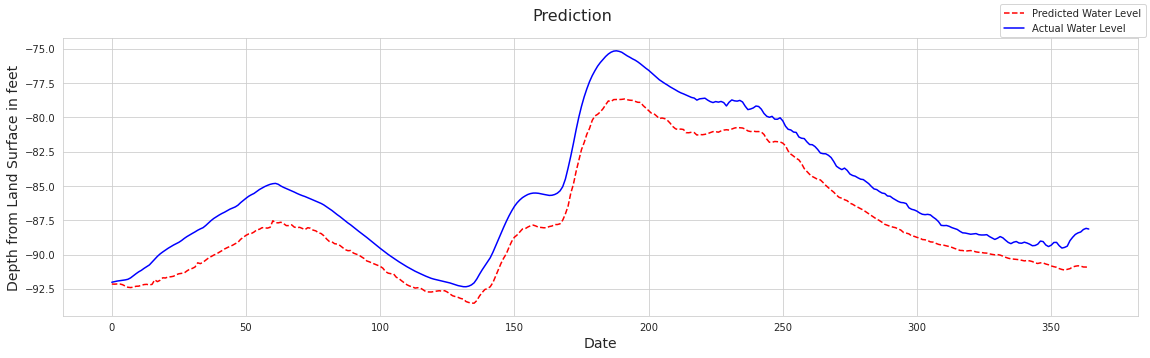

(     Predictions    Actuals
 0      92.148796  92.018750
 1      92.158638  91.977083
 2      92.144928  91.933750
 3      92.145706  91.905833
 4      92.196098  91.872500
 ..           ...        ...
 360    90.819252  88.420417
 361    90.842789  88.355000
 362    90.906937  88.173913
 363    90.911186  88.089583
 364    90.940094  88.137826
 
 [365 rows x 2 columns],
 4.5989071945572215)

In [30]:
plot_predictions2(np.array(preds)*well_training_std +well_training_mean, y_test_df)

In [36]:
np.sqrt(5.1893)

2.2780035118497954

[1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1021,
 1022,
 1023,
 1024,
 1025,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056,
 1057,
 1058,
 1059,
 1060,
 1061,
 1062,
 1063,
 1064,
 1065,
 1066,
 1067,
 1068,
 1069,
 1070,
 1071,
 1072,
 1073,
 1074,
 1075,
 1076,
 1077,
 1078,
 1079,
 1080,
 1081,
 1082,
 1083,
 1084,
 1085,
 1086,
 1087,
 1088,
 1089,
 1090,
 1091,
 1092,
 1093,
 1094,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1120,
 1121,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1128,
 1129,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,